This notebook is a tutorial for computing SEACell metacells, visualizing results and computing evaluation metrics

# Imports

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
import SEACells

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Some plotting aesthetics
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100


# Load Data

We recommend the use of scanpy Anndata objects as the preferred mode of loading and filtering data.

A sample datset is available for download with the instructions listed below. This is a filtered, unnormalized counts of single-nuclear RNA-seq dataset of CD34+ sorted bone marrow cells to profile human hematopoiesis [Dataset ref TBD].

Uncomment the following lines to download the sample dataset in a Unix-based system. For non-UNIX systems, download the files using the URL

In [5]:
# !mkdir data/
# !wget https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/cd34_multiome_rna.h5ad -O data/cd34_multiome_rna.h5ad 

In [6]:
# Load the data using 
ad = sc.read('data/cd34_multiome_rna.h5ad')

In [7]:
ad

AnnData object with n_obs × n_vars = 6881 × 12464
    obs: 'leiden', 'celltype'
    var: 'highly_variable'
    uns: 'celltype_colors'
    obsm: 'X_umap'

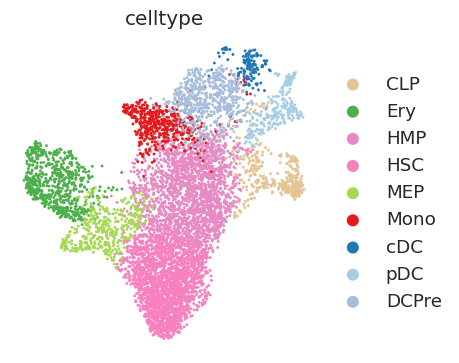

In [8]:
# Plot cell-types for reference
sc.pl.scatter(ad, basis='umap', color='celltype', frameon=False)

# Pre-processing

The following section describes basic pre-processing steps for scRNA-seq. For scATAC-seq, we provide a pipeline for pre-processing in  in example notebook `preprocessing-ATAC.ipynb`

In [9]:
# Copy the counts to ".raw" attribute of the anndata since it is necessary for downstream analysis
# This step should be performed after filtering 
raw_ad = sc.AnnData(ad.X)
raw_ad.obs_names, raw_ad.var_names = ad.obs_names, ad.var_names
ad.raw = raw_ad

In [10]:
# Normalize cells, log transform and compute highly variable genes
sc.pp.normalize_per_cell(ad)
sc.pp.log1p(ad)
sc.pp.highly_variable_genes(ad, n_top_genes=1500)

In [11]:
# Compute principal components - 
# Here we use 50 components. This number may also be selected by examining variance explaint
sc.tl.pca(ad, n_comps=50, use_highly_variable=True)

In [12]:
ad

AnnData object with n_obs × n_vars = 6881 × 12464
    obs: 'leiden', 'celltype', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'log1p', 'hvg', 'pca'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'

# Running SEACells

As a rule of thumb, we recommended choosing one metacell for every 75 single-cells. Since this dataset contains ~7k cells, we choose 90 metacells.

<b>Note 1: </b> Running SEACells modifies the input Anndata object and adds the SEACell metacell assignments to the `obs` dataframe in the anndata object.
<b>Note 2: </b> This analysis takes approxmiately 5 minutes

In [26]:
## User defined parameters

## Core parameters 
n_SEACells = 90
build_kernel_on = 'X_pca' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells
waypoint_proportion = 1 # Proportion of metacells to initialize using waypoint analysis, 
                        # the remainder of cells are selected by greedy selection

In [14]:
model = SEACells.core.SEACells(ad, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  waypt_proportion=waypoint_proportion,
                  convergence_epsilon = 1e-5)

model.fit(n_iter=20)


Building kernel...
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/6881 [00:00<?, ?it/s]

Making graph symmetric...
Computing RBF kernel...


  0%|          | 0/6881 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/6881 [00:00<?, ?it/s]

Constructing CSR matrix...
Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 83 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


  0%|          | 0/17 [00:00<?, ?it/s]

Selecting 7 cells from greedy initialization.
Randomly initialized A matrix.
Setting convergence threshold at 0.005820670139397217
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 20 iterations.


# Accessing results

## Model Parameters

The SEACells model oject has the following attributes

## Model Convergence

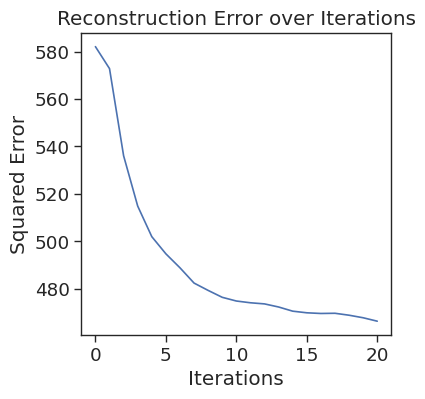

In [15]:
# Check for convergence 
model.plot_convergence()

## SEACell Assignments

These can be accessed as folows:
- in the modified anndata object in `.obs['SEAell']`
- from the model using `.get_assignments()`


In [16]:
ad.obs[['SEACell']].head()

,SEACell
index,
cd34_multiome_rep1#AAACAGCCACTCGCTC-1,cd34_multiome_rep1#GAGTCATTCGGTTCCT-1
cd34_multiome_rep1#AAACAGCCACTGACCG-1,cd34_multiome_rep2#GTGGCTTCAAGGTCCT-1
cd34_multiome_rep1#AAACAGCCATAATCAC-1,cd34_multiome_rep1#TAGCTAGGTAGGTTAT-1
cd34_multiome_rep1#AAACATGCAAATTCGT-1,cd34_multiome_rep1#CCATAGCCATGGCCTG-1
cd34_multiome_rep1#AAACATGCAGCATGTC-1,cd34_multiome_rep1#TAATTGCCACAATGTT-1


In [17]:
model.get_assignments().head()

,SEACell
index,
cd34_multiome_rep1#AAACAGCCACTCGCTC-1,cd34_multiome_rep1#GAGTCATTCGGTTCCT-1
cd34_multiome_rep1#AAACAGCCACTGACCG-1,cd34_multiome_rep2#GTGGCTTCAAGGTCCT-1
cd34_multiome_rep1#AAACAGCCATAATCAC-1,cd34_multiome_rep1#TAGCTAGGTAGGTTAT-1
cd34_multiome_rep1#AAACATGCAAATTCGT-1,cd34_multiome_rep1#CCATAGCCATGGCCTG-1
cd34_multiome_rep1#AAACATGCAGCATGTC-1,cd34_multiome_rep1#TAATTGCCACAATGTT-1


# Summarizing data

- `core.summarize_by_SEACell()`

Datasets can be summarized by SEACell by aggregating cells within each SEACell, summing over all raw data for all cells belonging to a SEACell. The output of this function is an anndata object of shape n_metacells x original_data_dimension. Data is unnormalized and raw aggregated counts are stored .layers['raw']. Attributes associated with variables (.var) are copied over, but relevant per SEACell attributes must be manually copied, since certain attributes may need to be summed, or averaged etc, depending on the attribute.



In [18]:
SEACell_ad = SEACells.core.summarize_by_SEACell(ad, SEACells_label='SEACell')
SEACell_ad

  0%|          | 0/90 [00:00<?, ?it/s]

AnnData object with n_obs × n_vars = 90 × 12464

# Evaluating Results

We provide several methods for evaluating SEACell assignments:

## Visualizing Results

Metacells also implements methods for visualizing the results of the Metacells algorithm 
    <ul> 
        <li>```.plot_2D()``` provides an interface for viewing metacell assignments on any 2-dimensional embedding in ad.obsm. Plots can also be coloured by metacell assignment.
        <li>```.plot_SEACell_sizes()``` can be used to view the distribution of number of cells assigned to each metacell
    </ul>
    
            

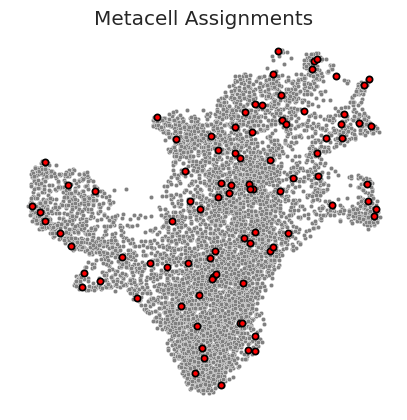

In [19]:
SEACells.plot.plot_2D(ad, key='X_umap', colour_metacells=False)

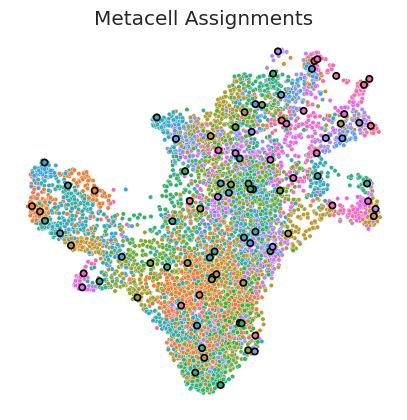

In [20]:
SEACells.plot.plot_2D(ad, key='X_umap', colour_metacells=True)

/home/msetty/.conda/envs/squidpy/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


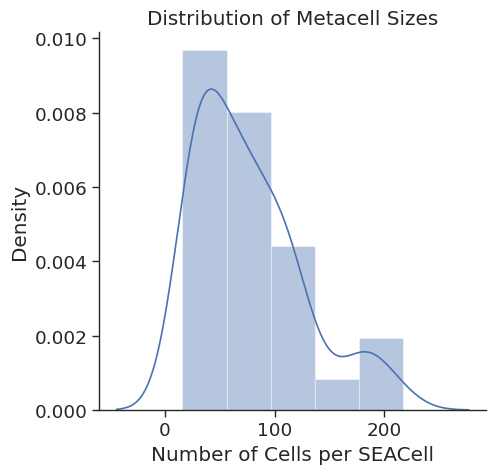

,size
SEACell,
cd34_multiome_rep1#AACCCGCAGCGCAATT-1,103
cd34_multiome_rep1#AACGCCCAGTCACTCC-1,32
cd34_multiome_rep1#AATCCGTAGCGGTTAT-1,37
cd34_multiome_rep1#AGTTGGCGTAGTAAGA-1,113
cd34_multiome_rep1#ATACCGGTCGTACCGA-1,26
...,...
cd34_multiome_rep2#TGTCCTGGTCACGAAC-1,41
cd34_multiome_rep2#TTAAGTGTCATTGTCT-1,94
cd34_multiome_rep2#TTCGTTAGTCCTAAGA-1,40


In [21]:
SEACells.plot.plot_SEACell_sizes(ad, bins=5)

## Quantifying Results

SEACells also implements methods for visualizing the results of the SEACells algorithm 
    <ul> 
        <li>```.compute_celltype_purity(ad, col_name)``` computes the purity of different celltype labels within a SEACell metacell. Typically, col_name='celltype' or similar. Returns a pd.DataFrame of length n_SEACells.
        <li>```.diffusion_component_variance(ad, low_dim_embedding)``` computes the per-SEAcell variance in diffusion components. ```low_dim_embedding``` is a string specifying the low dimensional embedding with which diffusion components are calculated, typically 'X_pca' for RNA or 'X_svd' for ATAC. Lower values of compactness suggest more compact/lower variance metacells.
        <li>```diffusion_component_dist_to_NN(ad, low_dim_embedding,nth_nbr=1,cluster=None)``` computes the diffusion distance between a SEACell and its ```nth_nbr```. As before, ```low_dim_embedding``` is a string specifying the low dimensional embedding with which diffusion components are calculated, typically 'X_pca' for RNA or 'X_svd' for ATAC. If ```cluster``` is provided as a string, e.g. 'celltype', nearest neighbors are restricted to have the same celltype value.  Higher values of separation suggest better distinction between metacells.
    </ul>
    


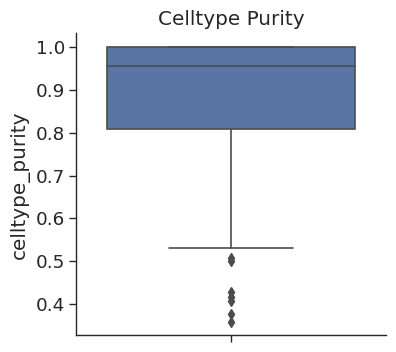

,celltype,celltype_purity
SEACell,,
cd34_multiome_rep1#AACCCGCAGCGCAATT-1,DCPre,1.000000
cd34_multiome_rep1#AACGCCCAGTCACTCC-1,MEP,0.625000
cd34_multiome_rep1#AATCCGTAGCGGTTAT-1,CLP,0.918919
cd34_multiome_rep1#AGTTGGCGTAGTAAGA-1,CLP,0.530973
cd34_multiome_rep1#ATACCGGTCGTACCGA-1,pDC,0.961538


In [22]:
SEACell_purity = SEACells.evaluate.compute_celltype_purity(ad, 'celltype')

plt.figure(figsize=(4,4))
sns.boxplot(data=SEACell_purity, y='celltype_purity')
plt.title('Celltype Purity')
sns.despine()
plt.show()
plt.close()

SEACell_purity.head()

Determing nearest neighbor graph...


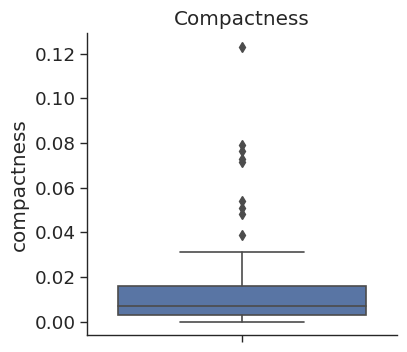

,compactness
SEACell,
cd34_multiome_rep1#AACCCGCAGCGCAATT-1,0.003600
cd34_multiome_rep1#AACGCCCAGTCACTCC-1,0.014125
cd34_multiome_rep1#AATCCGTAGCGGTTAT-1,0.122916
cd34_multiome_rep1#AGTTGGCGTAGTAAGA-1,0.022826
cd34_multiome_rep1#ATACCGGTCGTACCGA-1,0.016096


In [23]:
compactness = SEACells.evaluate.diffusion_component_variance(ad, 'X_pca')

plt.figure(figsize=(4,4))
sns.boxplot(data=compactness, y='compactness')
plt.title('Compactness')
sns.despine()
plt.show()
plt.close()

compactness.head()

Determing nearest neighbor graph...


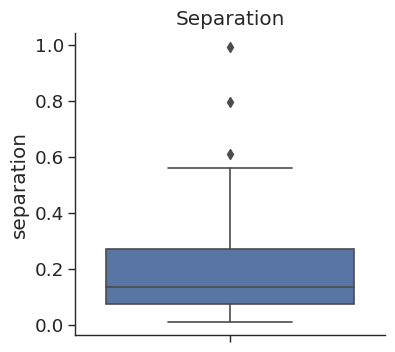

,separation
SEACell,
cd34_multiome_rep1#AACCCGCAGCGCAATT-1,0.282017
cd34_multiome_rep1#AACGCCCAGTCACTCC-1,0.212701
cd34_multiome_rep1#AATCCGTAGCGGTTAT-1,0.262092
cd34_multiome_rep1#AGTTGGCGTAGTAAGA-1,0.441527
cd34_multiome_rep1#ATACCGGTCGTACCGA-1,0.291050


In [24]:
separation = SEACells.evaluate.diffusion_component_dist_to_NN(ad, 'X_pca',nth_nbr=1)

plt.figure(figsize=(4,4))
sns.boxplot(data=separation, y='separation')
plt.title('Separation')
sns.despine()
plt.show()
plt.close()

separation.head()

# Downstream Analyses

## Peak-Gene Associations

<b> MS: </b> The data points to a location on your computer. This needs to be updated. 
We need to create a toydataset because this analysis is far too slow

In [ ]:
import scanpy as sc

# Load multiome anndata objects containing SEACell assignments. Change these according to your files.
data_dir = '/Users/sitarapersad/data/'

rna_ad = sc.read(data_dir+'SEACells/cd34_multiome_rna_no_bcells/cd34_multiome_rna_no_bcells.h5ad')
atac_ad = sc.read(data_dir+'SEACells/cd34_multiome_atac_no_bcells/cd34_multiome_atac_no_bcells.h5ad')

# Check to ensure the following attributes are present in your anndata objects

atac_ad.var['GC'], atac_ad.var['log_n_counts']
rna_ad.var['highly_variable']



In [ ]:
from SEACells.gene_scores import *

# Prepare inputs for downstream analysis (TFIDF transformation of ATAC data, aggregation by SEACell)
processed_atac_ad, atac_aggregated_ad, rna_aggregated_ad = prepare_multiome_anndata(atac_ad, rna_ad, SEACell_label='SEACell')

In [ ]:
del atac_ad
del rna_ad

In [ ]:
# This function requires you to have the hg38.gtf, which can be downloaded
# at http://genome.ucsc.edu/cgi-bin/hgTables. Select output format: GTF

# Grab a snack: This cell is computationally intensive and may take some time to complete running. 

path_to_hg38gtf = data_dir+ 'genomes/hg38.gtf'

transcripts = gene_scores_temp.load_transcripts(path_to_hg38gtf)

print('Loaded transcripts.')

gene_peak_assoc = gene_scores_temp.get_gene_peak_associations(atac_aggregated_ad,
                                               rna_aggregated_ad,
                                               processed_atac_ad,
                                               transcripts,
                                               span=100000)


In [ ]:
# Compute the aggregate accessibility of all peaks associated with each gene
gene_scores = get_gene_scores(atac_aggregated_ad, 
                              gene_peak_assoc)


In [ ]:
import pickle
with open(out_dir + 'correlations.p', 'wb') as p:
    pickle.dump(gene_peak_assoc, p)
with open(out_dir + 'gene_scores.p', 'wb') as p:
    pickle.dump(gene_scores, p)